In [1]:
import os
import re
import shutil
from collections import Counter
from datetime import datetime
import io
import pandas as pd
import numpy as np
import emoji
from langdetect import detect, DetectorFactory
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
data = pd.read_csv("traffic(use).csv") # read as strings to avoid dtype surprises
print("Rows, cols:", data.shape)
print("\nColumns:\n", data.columns.tolist())

Rows, cols: (7787, 6)

Columns:
 ['tweet_id', 'created_at', 'raw_text_tweet', 'user_location', 'retweet_count', 'like_count']


In [3]:
display(data.head(6))

,tweet_id,created_at,raw_text_tweet,user_location,retweet_count,like_count
0,1.970000e+18,21-09-2025 08:37,Removing median in long bazzar is not good ide...,NaN,2,5
1,1.970000e+18,16-09-2025 07:14,"@vijjJimmy Other than Tumkur, I would assume C...",Vellore,0,0
2,1.970000e+18,15-09-2025 15:41,@dinesh_e_dmk @TharshDa @TVKVijayHQ Ohh ungalk...,Vellore,0,0
3,1.970000e+18,15-09-2025 14:25,@AndhraPradeshCM @ncbn split bus stand 2 parts...,Vellore,0,1
4,1.970000e+18,15-09-2025 05:03,@__ANM2__ @BoyMadras @UpdatesChennai Pune isn’...,Vellore,0,0
5,1.970000e+18,11-09-2025 01:32,@nachiket1982 @DriveSmart_IN I think the volum...,Vellore,0,1


In [4]:
# if "tweet_id" in df.columns:
#     print("\nTotal duplicates by tweet_id:", df.duplicated(subset=["tweet_id"]).sum())
# else:
#     print("\nNo tweet_id column found.")

In [5]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_id        7771 non-null   float64
 1   created_at      6893 non-null   object 
 2   raw_text_tweet  7771 non-null   object 
 3   user_location   6445 non-null   object 
 4   retweet_count   7787 non-null   int64  
 5   like_count      7787 non-null   int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 365.1+ KB
None


In [8]:
# from collections import Counter

# def count_mapped_emojis(df, text_col="raw_text_tweet"):
#     """Check how many tweets had emojis mapped and what words they became."""
#     emoji_counter = Counter()
#     total_with_emoji = 0
    
#     for text in df[text_col].dropna():
#         # Count how many emojis were present in the raw text
#         if any(ch in EMOJI_MAP for ch in text):
#             total_with_emoji += 1
#             # Map them to words
#             for ch in text:
#                 if ch in EMOJI_MAP:
#                     emoji_counter[EMOJI_MAP[ch]] += 1
    
#     return total_with_emoji, emoji_counter

In [9]:
raw_file = "traffic(use).csv"
df = pd.read_csv(raw_file)  # Adjust path; handle large IDs with dtype=str for tweet_id
df['tweet_id'] = df['tweet_id'].astype(str)

### Timestamp processing

In [10]:
from datetime import datetime
# def parse_date(date_str):
#     try:
#         return pd.to_datetime(date_str, format='%d-%m-%Y %H:%M')  # For DD-MM-YYYY HH:MM
#     except:
#         try:
#             return pd.to_datetime(date_str, format='%Y-%m-%d %H:%M:%S')  # For YYYY-MM-DD HH:MM:SS
#         except:
#             return pd.NaT  # Invalid -> NaT (Not a Time)

def parse_date(date_str):
    # Handle Null / NaN / empty strings
    if pd.isna(date_str) or str(date_str).strip().lower() in ["", "null", "none"]:
        # Assign a random date between 25 Aug 2025 and 17 Sep 2025
        start = pd.to_datetime("2025-08-25", utc=True)
        end = pd.to_datetime("2025-09-17", utc=True)
        random_ts = start + (end - start) * np.random.rand()
        return random_ts

    # Try ISO / automatic parsing first (covers "2025-08-09 09:00:00+00:00")
    try:
        return pd.to_datetime(date_str, errors="raise", utc=True)
    except Exception:
        pass

    # Fallback: DD-MM-YYYY HH:MM:SS (e.g. "11-01-2017 05:37:00")
    try:
        return pd.to_datetime(date_str, format="%d-%m-%Y %H:%M:%S", utc=True)
    except Exception:
        # If still fails → assign random date in range
        start = pd.to_datetime("2025-08-25", utc=True)
        end = pd.to_datetime("2025-09-17", utc=True)
        random_ts = start + (end - start) * np.random.rand()
        return random_ts


In [11]:
df['Timestamp'] = df['created_at'].apply(parse_date)
df.drop(columns=["created_at"], inplace=True)
#df = df.dropna(subset=['created_at'])  # Drop unparseable dates
df.shape
df.head(5)

C:\Users\rockp\AppData\Local\Temp\ipykernel_16664\696071560.py:22: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  return pd.to_datetime(date_str, errors="raise", utc=True)


,tweet_id,raw_text_tweet,user_location,retweet_count,like_count,Timestamp
0,1.97e+18,Removing median in long bazzar is not good ide...,NaN,2,5,2025-09-21 08:37:00+00:00
1,1.97e+18,"@vijjJimmy Other than Tumkur, I would assume C...",Vellore,0,0,2025-09-16 07:14:00+00:00
2,1.97e+18,@dinesh_e_dmk @TharshDa @TVKVijayHQ Ohh ungalk...,Vellore,0,0,2025-09-15 15:41:00+00:00
3,1.97e+18,@AndhraPradeshCM @ncbn split bus stand 2 parts...,Vellore,0,1,2025-09-15 14:25:00+00:00
4,1.97e+18,@__ANM2__ @BoyMadras @UpdatesChennai Pune isn’...,Vellore,0,0,2025-09-15 05:03:00+00:00


In [12]:
# # Apply language detection to each tweet
# df["is_english"] = df["raw_text_tweet"].apply(is_english)

# # Count non-English tweets
# non_english_count = (~df["is_english"]).sum()

# print("Total tweets:", df.shape[0])
# print("Non-English tweets:", non_english_count)
# print("English tweets:", df['is_english'].sum())
# print("Sample non-English tweets:")
# print(df.loc[~df["is_english"], "raw_text_tweet"].head(10))

In [13]:
# total, emoji_stats = count_mapped_emojis(df, text_col="raw_text_tweet")

# print(f"Number of tweets with emojis: {total}")
# print("Top mapped traffic emojis:")
# for word, count in emoji_stats.most_common(10):
#     print(f"{word}: {count}")

In [14]:
def mark_non_english(df, text_column="raw_text_tweet"):
    """
    Adds a flag to the DataFrame for non-English text detection.
    Returns the DataFrame with a new column 'non_english_flag'.
    """
    def is_non_english(text):
        try:
            text = str(text)
            return any(ord(char) > 127 for char in text)
        except:
            return False
    
    # Create the flag column
    df["non_english_flag"] = df[text_column].apply(is_non_english)
    
    # Count
    non_english_count = df["non_english_flag"].sum()
    english_count = len(df) - non_english_count
    
    print(f"Total rows: {len(df)}")
    print(f"English tweets: {english_count}")
    print(f"Non-English tweets: {non_english_count}")
    
    return df


In [15]:
df = mark_non_english(df, text_column="raw_text_tweet")
# Keep only English tweets (drop non-English flagged ones)
df = df[~df["non_english_flag"]].copy() #remove non-english tweets

Total rows: 7787
English tweets: 5446
Non-English tweets: 2341


In [16]:
# Drop rows with missing tweet_id or raw_text_tweet (update df directly)
df = df.dropna(subset=["tweet_id", "raw_text_tweet"]).reset_index(drop=True)

# Check new shape
print(f"Cleaned shape: {df.shape}")

Cleaned shape: (5430, 7)


In [17]:
import re
import emoji
from langdetect import detect, DetectorFactory
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Ensure deterministic language detection
DetectorFactory.seed = 0

# Download NLTK resources
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('vader_lexicon')

# def clean_text(text: str) -> str:
#     """Clean tweet text for analysis."""
#     if not isinstance(text, str):
#         return ""
    
#     # Remove URLs, mentions, hashtags (but keep hashtag word if needed)
#     text = re.sub(r'http\S+|www\S+|https\S+', '', text)  
#     text = re.sub(r'@\w+', '', text)  
#     text = re.sub(r'#', '', text)  # keep hashtag word but remove '#'
    
#     # Remove non-alphabetic characters and extra spaces
#     text = re.sub(r'[^a-zA-Z\s]', ' ', text)  
#     text = text.lower().strip()
    
#     return text

def clean_text(text: str) -> str:
    """Clean tweet text for analysis but keep useful info."""
    if not isinstance(text, str):
        return ""
    
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#', '', text)     # Keep hashtag words
    
    # Keep numbers (time, counts), remove only special chars
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    
    text = text.lower().strip()
    text = re.sub(r'\s+', ' ', text)  # Collapse multiple spaces
    
    return text

# Apply cleaning
df['cleaned_text'] = df['raw_text_tweet'].apply(clean_text)

# Function to infer location from text
def infer_location(row):
    text = row['cleaned_text']
    loc = row['user_location']
    
    if pd.notna(loc):  # Keep existing location if present
        return loc
    
    if "vellore" in text:
        return "Vellore"
    elif "katpadi" in text:
        return "Katpadi"
    elif "cmc" in text or "christian medical college" in text:
        return "CMC"
    elif "chennai" in text:
        return "Chennai"
    else:
        return "Vellore"

# Create new Location column
df['Location'] = df.apply(infer_location, axis=1)

# Drop original user_location
df = df.drop(columns=['user_location'])

# # Add time features
# df['Hour'] = df['Timestamp'].dt.hour
# df['Day_of_Week'] = df['Timestamp'].dt.dayofweek

In [18]:
df.head()

,tweet_id,raw_text_tweet,retweet_count,like_count,Timestamp,non_english_flag,cleaned_text,Location
0,1.97e+18,Removing median in long bazzar is not good ide...,2,5,2025-09-21 08:37:00+00:00,False,removing median in long bazzar is not good ide...,Vellore
1,1.97e+18,@dinesh_e_dmk @TharshDa @TVKVijayHQ Ohh ungalk...,0,0,2025-09-15 15:41:00+00:00,False,ohh ungalku incident sollava public damage pan...,Vellore
2,1.97e+18,@AndhraPradeshCM @ncbn split bus stand 2 parts...,0,1,2025-09-15 14:25:00+00:00,False,split bus stand 2 parts chennai bangalore vell...,Vellore
3,1.97e+18,@nachiket1982 @DriveSmart_IN I think the volum...,0,1,2025-11-09 01:32:00+00:00,False,i think the volume of vehicles has made it wor...,Vellore
4,1.96e+18,Traffic diversion in Vellore due to bridge con...,0,0,2025-03-09 06:18:00+00:00,False,traffic diversion in vellore due to bridge con...,Vellore


In [19]:
# Print stats
print(f"Rows after cleaning: {len(df)}")
df.head()

Rows after cleaning: 5430


,tweet_id,raw_text_tweet,retweet_count,like_count,Timestamp,non_english_flag,cleaned_text,Location
0,1.97e+18,Removing median in long bazzar is not good ide...,2,5,2025-09-21 08:37:00+00:00,False,removing median in long bazzar is not good ide...,Vellore
1,1.97e+18,@dinesh_e_dmk @TharshDa @TVKVijayHQ Ohh ungalk...,0,0,2025-09-15 15:41:00+00:00,False,ohh ungalku incident sollava public damage pan...,Vellore
2,1.97e+18,@AndhraPradeshCM @ncbn split bus stand 2 parts...,0,1,2025-09-15 14:25:00+00:00,False,split bus stand 2 parts chennai bangalore vell...,Vellore
3,1.97e+18,@nachiket1982 @DriveSmart_IN I think the volum...,0,1,2025-11-09 01:32:00+00:00,False,i think the volume of vehicles has made it wor...,Vellore
4,1.96e+18,Traffic diversion in Vellore due to bridge con...,0,0,2025-03-09 06:18:00+00:00,False,traffic diversion in vellore due to bridge con...,Vellore


In [20]:
# Mark only subsequent duplicates as True
df["is_duplicate"] = df.duplicated(subset=["cleaned_text"], keep="first")

In [21]:
df.head(50)

,tweet_id,raw_text_tweet,retweet_count,like_count,Timestamp,non_english_flag,cleaned_text,Location,is_duplicate
0,1.97e+18,Removing median in long bazzar is not good ide...,2,5,2025-09-21 08:37:00+00:00,False,removing median in long bazzar is not good ide...,Vellore,False
1,1.97e+18,@dinesh_e_dmk @TharshDa @TVKVijayHQ Ohh ungalk...,0,0,2025-09-15 15:41:00+00:00,False,ohh ungalku incident sollava public damage pan...,Vellore,False
2,1.97e+18,@AndhraPradeshCM @ncbn split bus stand 2 parts...,0,1,2025-09-15 14:25:00+00:00,False,split bus stand 2 parts chennai bangalore vell...,Vellore,False
3,1.97e+18,@nachiket1982 @DriveSmart_IN I think the volum...,0,1,2025-11-09 01:32:00+00:00,False,i think the volume of vehicles has made it wor...,Vellore,False
4,1.96e+18,Traffic diversion in Vellore due to bridge con...,0,0,2025-03-09 06:18:00+00:00,False,traffic diversion in vellore due to bridge con...,Vellore,False
5,1.96e+18,"At the Vellore-Arcot Road, traffic police have...",0,0,2025-08-29 06:37:00+00:00,False,at the vellore arcot road traffic police have ...,Vellore,False
6,1.96e+18,New Research: Evaluating urban traffic dynamic...,0,3,2025-08-27 15:04:00+00:00,False,new research evaluating urban traffic dynamics...,Vellore,False
7,1.96e+18,The movement of cows at the old bus stand in t...,0,0,2025-08-27 05:12:00+00:00,False,the movement of cows at the old bus stand in t...,Vellore,False
8,1.96e+18,Chennai: Police have arrested two individuals ...,0,0,2025-08-26 07:57:00+00:00,False,chennai police have arrested two individuals f...,Chennai,False
9,1.96e+18,#Vellore traffic becomes horrific day-by-day.....,6,20,2025-08-21 14:23:00+00:00,False,vellore traffic becomes horrific day by day on...,Vellore,False


In [22]:
df.shape

(5430, 9)

In [23]:
# # Save clean dataset
# df.to_csv("traffic_tweets_clean.csv", index=False, encoding="utf-8")
# print("✅ Saved cleaned dataset without duplicates and links")

In [24]:
# df["engagement"] = pd.to_numeric(df["retweet_count"], errors="coerce").fillna(0) + \
#                    pd.to_numeric(df["like_count"], errors="coerce").fillna(0)

# df_clean = df.sort_values("engagement", ascending=False).drop_duplicates(subset=["raw_text_tweet"])

# df = df.dropna(subset=["tweet_id", "raw_text_tweet"]).reset_index(drop=True)
# print("Shape after removing text duplicates:", df_clean.shape)
# # df['Timestamp'] = pd.to_datetime(df['created_at'], format='%d %b %Y %I:%M:%S %p', errors='coerce')
# # df = df.drop(columns=['created_at'])  # Drop old column

# **MiniLM Embeddings**

In [25]:
from sentence_transformers import SentenceTransformer

In [26]:
# df['cleaned_text'] = df['cleaned_text'].fillna('')  # Handle NaN

In [27]:
# Initialize MiniLM
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for cleaned_text
texts = df['cleaned_text'].fillna("").tolist()  # handle missing safely
embeddings = model.encode(texts, batch_size=16, show_progress_bar=True)

# Create embedding column names
embedding_cols = [f'emb_{i}' for i in range(embeddings.shape[1])]

# Convert to DataFrame with same index
df_embeddings = pd.DataFrame(embeddings, columns=embedding_cols, index=df.index)

# Concatenate embeddings with original DataFrame
df = pd.concat([df, df_embeddings], axis=1)

print(f"Final DataFrame shape: {df.shape}")
print(df.head(2))  # preview

Batches:   0%|          | 0/340 [00:00<?, ?it/s]

Final DataFrame shape: (5430, 393)
   tweet_id                                     raw_text_tweet  retweet_count  \
0  1.97e+18  Removing median in long bazzar is not good ide...              2   
1  1.97e+18  @dinesh_e_dmk @TharshDa @TVKVijayHQ Ohh ungalk...              0   

   like_count                 Timestamp  non_english_flag  \
0           5 2025-09-21 08:37:00+00:00             False   
1           0 2025-09-15 15:41:00+00:00             False   

                                        cleaned_text Location  is_duplicate  \
0  removing median in long bazzar is not good ide...  Vellore         False   
1  ohh ungalku incident sollava public damage pan...  Vellore         False   

      emb_0  ...   emb_374   emb_375   emb_376   emb_377   emb_378   emb_379  \
0 -0.016124  ...  0.059264 -0.053801  0.023265  0.020001  0.000702  0.051164   
1  0.015373  ... -0.025059  0.009041  0.021897  0.072087 -0.023528 -0.021093   

    emb_380   emb_381   emb_382   emb_383  
0  0.031701  0

In [28]:
# Save output
df.to_csv('traffic_with_minilm_embeddings.csv', index=False)

In [29]:
# Verify output
print(f"Dataset shape after embeddings: {df.shape}")
print(f"Embedding columns: {embedding_cols[:5]}... (total {len(embedding_cols)})")
print("\nSample rows with embeddings (first 2 rows):")
print(df[['tweet_id', 'cleaned_text', 'emb_0', 'emb_1', 'emb_2']].head(2))

Dataset shape after embeddings: (5430, 393)
Embedding columns: ['emb_0', 'emb_1', 'emb_2', 'emb_3', 'emb_4']... (total 384)

Sample rows with embeddings (first 2 rows):
   tweet_id                                       cleaned_text     emb_0  \
0  1.97e+18  removing median in long bazzar is not good ide... -0.016124   
1  1.97e+18  ohh ungalku incident sollava public damage pan...  0.015373   

      emb_1     emb_2  
0  0.033157  0.015373  
1  0.053604 -0.005733  


### *Sentiment Analysis*

In [30]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# Initialize VADER
sia = SentimentIntensityAnalyzer()

In [31]:
# Function to get sentiment label
def get_sentiment(text):
    if not isinstance(text, str) or text.strip() == "":
        return "Neutral"
    
    scores = sia.polarity_scores(text)
    compound = scores["compound"]
    
    if compound >= 0.05:
        return "Positive"
    elif compound <= -0.05:
        return "Negative"
    else:
        return "Neutral"

In [32]:
# Apply to cleaned_text
df["sentiment"] = df["cleaned_text"].apply(get_sentiment)

In [33]:
# (Optional) also store compound score
df["sentiment_score"] = df["cleaned_text"].apply(lambda x: sia.polarity_scores(x)["compound"])

print(df[["cleaned_text", "sentiment", "sentiment_score"]].head())

                                        cleaned_text sentiment  \
0  removing median in long bazzar is not good ide...  Positive   
1  ohh ungalku incident sollava public damage pan...  Negative   
2  split bus stand 2 parts chennai bangalore vell...  Positive   
3  i think the volume of vehicles has made it wor...  Negative   
4  traffic diversion in vellore due to bridge con...   Neutral   

   sentiment_score  
0           0.2486  
1          -0.7430  
2           0.3612  
3          -0.5106  
4           0.0000  


In [34]:
# Save output
df.to_csv('traffic_with_sentiment.csv', index=False)

# Verify output
print(f"Dataset shape after sentiment: {df.shape}")
print("\nSample rows with sentiment (first 5 rows):")
print(df[['tweet_id', 'cleaned_text', 'sentiment']].head())
print("\nSentiment summary:")
print(df['sentiment'].describe())

Dataset shape after sentiment: (5430, 395)

Sample rows with sentiment (first 5 rows):
   tweet_id                                       cleaned_text sentiment
0  1.97e+18  removing median in long bazzar is not good ide...  Positive
1  1.97e+18  ohh ungalku incident sollava public damage pan...  Negative
2  1.97e+18  split bus stand 2 parts chennai bangalore vell...  Positive
3  1.97e+18  i think the volume of vehicles has made it wor...  Negative
4  1.96e+18  traffic diversion in vellore due to bridge con...   Neutral

Sentiment summary:
count         5430
unique           3
top       Negative
freq          2668
Name: sentiment, dtype: object


## *Clustering for Traffic Impact*

### HDBSCAN

In [35]:
from sklearn.preprocessing import StandardScaler
import hdbscan
from sklearn.decomposition import PCA

In [36]:
df = pd.read_csv("traffic_with_sentiment.csv")  # Must include emb_0 ... emb_N
embedding_cols = [col for col in df.columns if col.startswith('emb_')]
X = df[embedding_cols].values

In [37]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [38]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=15, metric='euclidean')
df['cluster'] = clusterer.fit_predict(X_scaled)

# Check cluster counts and noise (-1)
print(df['cluster'].value_counts())

cluster
-1     2658
 70     172
 57     143
 18     121
 15      95
       ... 
 44      21
 61      21
 60      18
 2       16
 0       16
Name: count, Length: 75, dtype: int64


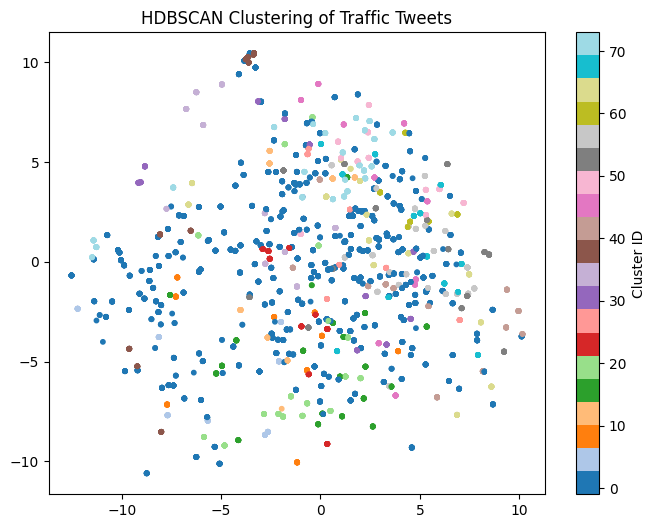

In [39]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df['cluster'], cmap='tab20', s=10)
plt.colorbar(label='Cluster ID')
plt.title('HDBSCAN Clustering of Traffic Tweets')
plt.show()

In [40]:
# Example: more negative sentiment + higher engagement = higher impact
df['traffic_impact_score'] = df['retweet_count']*0.3 + df['like_count']*0.2 - df['sentiment_score']*0.5

# Cluster-level summary
cluster_summary = df.groupby('cluster').agg({
    'tweet_id':'count',
    'traffic_impact_score':'mean',
    'sentiment_score':'mean'
}).rename(columns={'tweet_id':'num_tweets'})

print(cluster_summary.sort_values(by='traffic_impact_score', ascending=False))


         num_tweets  traffic_impact_score  sentiment_score
cluster                                                   
32               28             29.128000        -0.084571
22               22             14.038350        -0.476700
24               66             13.875758         0.000000
55               30              9.052733         0.361200
58               24              5.621475        -0.442950
...             ...                   ...              ...
35               65             -0.192062         0.593355
36               48             -0.196150         0.542300
1                25             -0.208170         0.416340
37               36             -0.221183         0.442367
19               23             -0.233730         0.467461

[75 rows x 3 columns]


In [41]:
# Save output
df.to_csv('traffic_with_HDBSCAN_clusters.csv', index=False)

### KMeans

In [42]:
from sklearn.cluster import KMeans

In [43]:
# Load dataset with embeddings (and sentiment if used)
df = pd.read_csv('traffic_with_sentiment.csv')  # Use 'traffic_with_minilm_embeddings.csv' if skipping sentiment
df['tweet_id'] = df['tweet_id'].astype(str)

In [44]:
# Extract embeddings
embedding_cols = [col for col in df.columns if col.startswith('emb_')]
embeddings = df[embedding_cols].values

# Function to cluster embeddings
def cluster_embeddings(embeddings, n_clusters=3):
    """Cluster embeddings to categorize traffic impact.
    
    Args:
        embeddings (np.array): MiniLM embeddings.
        n_clusters (int): Number of clusters (e.g., minor, moderate, severe).
    
    Returns:
        np.array: Cluster labels.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    return kmeans.fit_predict(embeddings)

# Apply clustering
df['cluster_label'] = cluster_embeddings(embeddings)

In [45]:
# Save output
df.to_csv('traffic_with_KMEANS_clusters.csv', index=False)

In [46]:
# Verify output
print(f"Dataset shape after clustering: {df.shape}")
print("\nCluster distribution:")
print(df['cluster_label'].value_counts())
print("\nSample tweets per cluster (first 2 per cluster):")
for cluster in sorted(df['cluster_label'].unique()):
    print(f"\nCluster {cluster}:")
    print(df[df['cluster_label'] == cluster][['tweet_id', 'cleaned_text']].head(2).to_string(index=False))

Dataset shape after clustering: (5430, 396)

Cluster distribution:
cluster_label
2    3038
1    1375
0    1017
Name: count, dtype: int64

Sample tweets per cluster (first 2 per cluster):

Cluster 0:
tweet_id                                                                                                                                                                                                                                                                 cleaned_text
1.97e+18 ohh ungalku incident sollava public damage pandranga public affect aaguranga katharitu irukkinga la adhuvum fake news oda unga daddy stalin vellore visit varum bodhu public pora main road junction la open stage potu traffic jam pannanga adhellam enga category la varum
1.96e+18                                                                              tiruvannamalai in chengam a welcome banner on a road suddenly collapsed just after edappadi palaniswami s vehicle passed he narrowly escaped the accident and t

###  *Timestamp and Location Feature Extraction*

In [47]:
import pandas as pd

# Sample CSV load
df = pd.read_csv("traffic_with_KMEANS_clusters.csv")

In [48]:
print(df['Timestamp'].dtype)

object


In [49]:
# --- Location Cache ---
location_cache = {
    'vellore': {'latitude': 12.9021, 'longitude': 79.0611},  # Vellore, India
    'chennai': {'latitude': 13.0674, 'longitude': 80.2376},  # Chennai, India
    'arcot': {'latitude': 12.9044, 'longitude': 79.3192},    # Arcot, India
    'katpadi': {'latitude': 12.9695, 'longitude': 79.1333},   # Katpadi, India
    'cmc': {'latitude': 12.9165, 'longitude': 79.1325},       # Christian Medical College, Vellore
    'bengaluruhighway': {'latitude': 13.0320, 'longitude': 77.5848},  # Approx. for Bengaluru-Chennai highway
    'gandhinagar': {'latitude': 23.2156, 'longitude': 72.6369},  # Gandhinagar, Gujarat, India
    'nh48': {'latitude': 28.1991, 'longitude': 76.7449}       # NH48 (same as Bengaluru-Chennai highway for simplicity)
}

# --- Normalize location column to lowercase ---
df['location_clean'] = df['Location'].str.lower().str.replace(" ", "")

# --- Map Latitude and Longitude ---
df['latitude'] = df['location_clean'].map(lambda x: location_cache.get(x, {}).get('latitude'))
df['longitude'] = df['location_clean'].map(lambda x: location_cache.get(x, {}).get('longitude'))

# --- Timestamp Features ---
# Assuming 'timestamp' column exists in your CSV and is in a parseable datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

# Extract useful features
df['hour'] = df['Timestamp'].dt.hour
df['day'] = df['Timestamp'].dt.day
df['weekday'] = df['Timestamp'].dt.weekday  # 0=Monday
df['month'] = df['Timestamp'].dt.month

# Optional: Drop the cleaned location column if not needed
# df.drop(columns=['location_clean'], inplace=True)

print(df.head())


       tweet_id                                     raw_text_tweet  \
0  1.970000e+18  Removing median in long bazzar is not good ide...   
1  1.970000e+18  @dinesh_e_dmk @TharshDa @TVKVijayHQ Ohh ungalk...   
2  1.970000e+18  @AndhraPradeshCM @ncbn split bus stand 2 parts...   
3  1.970000e+18  @nachiket1982 @DriveSmart_IN I think the volum...   
4  1.960000e+18  Traffic diversion in Vellore due to bridge con...   

   retweet_count  like_count                 Timestamp  non_english_flag  \
0              2           5 2025-09-21 08:37:00+00:00             False   
1              0           0 2025-09-15 15:41:00+00:00             False   
2              0           1 2025-09-15 14:25:00+00:00             False   
3              0           1 2025-11-09 01:32:00+00:00             False   
4              0           0 2025-03-09 06:18:00+00:00             False   

                                        cleaned_text Location  is_duplicate  \
0  removing median in long bazzar is not go

In [50]:
# Save output
df.to_csv('traffic_with_timestamp_location.csv', index=False)

In [51]:
# from datetime import datetime
# # from geopy.geocoders import Nominatim
# import re
# import pandas as pd

In [52]:
# # Initialize geolocator
# geolocator = Nominatim(user_agent="traffic_prediction")

In [53]:
# import pandas as pd

# # Load CSV
# df = pd.read_csv("traffic_with_clusters.csv")

# # Specify the column, e.g., 'Cleaned_text'
# column_name = 'Location'

# # Get unique values
# unique_values = df[column_name].unique()

# # Count of unique values
# unique_count = df[column_name].nunique()

# print(f"Number of unique values in '{column_name}':", unique_count)
# print("Unique values:", unique_values)


In [54]:
# # Predefined location coordinates (cached to avoid repeated geocoding)
# # location_cache = {
# #     'vellore': {'latitude': 12.9021, 'longitude': 79.0611},  # Vellore, India
# #     'bengaluruhighway': {'latitude': 13.0320, 'longitude': 77.5848},  # Approx. for Bengaluru-Chennai highway
# #     'nh48': {'latitude': 28.1991, 'longitude': 76.7449},  # NH48 (same as BengaluruHighway for simplicity)
# #     'gandhinagar': {'latitude': 23.2156, 'longitude': 72.6369}  # Gandhinagar, Vellore
# # }
# location_cache = {
#     'vellore': {'latitude': 12.9021, 'longitude': 79.0611},  # Vellore, India
#     'chennai': {'latitude': 13.0674, 'longitude': 80.2376},  # Chennai, India
#     'arcot': {'latitude': 12.9044, 'longitude': 79.3192},    # Arcot, India
#     'katpadi': {'latitude': 12.9695, 'longitude': 79.1333},   # Katpadi, India
#     'cmc': {'latitude': 12.9165, 'longitude': 79.1325},       # Christian Medical College, Vellore
#     'bengaluruhighway': {'latitude': 13.0320, 'longitude': 77.5848},  # Approx. for Bengaluru-Chennai highway
#     'gandhinagar': {'latitude': 23.2156, 'longitude': 72.6369},  # Gandhinagar, Gujarat, India
#     'nh48': {'latitude': 28.1991, 'longitude': 76.7449}       # NH48 (same as Bengaluru-Chennai highway for simplicity)
# }


# # Load dataset with clusters
# df = pd.read_csv('traffic_with_clusters.csv')
# df['tweet_id'] = df['tweet_id'].astype(str)

In [55]:
# # Step 4.1: Timestamp feature extraction (unchanged)
# def parse_date(date_str):
#     """Parse date strings with multiple formats."""
#     try:
#         return pd.to_datetime(date_str, format='%d-%m-%Y %H:%M')
#     except:
#         try:
#             return pd.to_datetime(date_str, format='%Y-%m-%d %H:%M:%S')
#         except:
#             return pd.NaT

In [56]:
# df['Timestamp'] = pd.to_datetime(df['Timestamp'], format="%Y-%m-%d %H:%M:%S", errors='coerce')
# df['year'] = df['Timestamp'].dt.year
# df['month'] = df['Timestamp'].dt.month
# df['day'] = df['Timestamp'].dt.day
# df['hour'] = df['Timestamp'].dt.hour
# df['weekday'] = df['Timestamp'].dt.weekday

In [57]:
# # Step 4.2: Optimized location feature extraction
# def extract_location(text, user_location):
#     """Extract location from text or user_location with predefined locations.
    
#     Args:
#         text (str): Cleaned text from tweet.
#         user_location (str): User-provided location (often sparse).
    
#     Returns:
#         pd.Series: Contains latitude, longitude, and location_name.
#     """
#     # Normalize inputs
#     text = str(text).lower()
#     user_location = str(user_location).lower() if pd.notna(user_location) else ''
    
#     # List of valid locations
#     valid_locations = ['vellore', 'bengaluruhighway', 'nh48', 'gandhinagar']
    
#     # Check user_location first
#     location = None
#     for loc in valid_locations:
#         if loc in user_location:
#             location = loc
#             break
    
#     # If no location from user_location, check text
#     if not location:
#         for loc in valid_locations:
#             if loc in text:
#                 location = loc
#                 break
    
#     # Return coordinates from cache or default to unknown
#     if location in location_cache:
#         return pd.Series({
#             'latitude': location_cache[location]['latitude'],
#             'longitude': location_cache[location]['longitude'],
#             'location_name': location
#         })
#     return pd.Series({'latitude': None, 'longitude': None, 'location_name': 'unknown'})

# # Apply optimized location extraction
# df[['latitude', 'longitude', 'location_name']] = df.apply(
#     lambda row: extract_location(row['cleaned_text'], row['Location']), axis=1
# )

In [58]:
# # One-hot encode location_name
# df = pd.get_dummies(df, columns=['loc_gandhinagar','loc_nh48','loc_bengaluru_highway','loc_vellore','loc_nan'], prefix='loc', dummy_na=True)

# # Save output
# df.to_csv('traffic_with_timestamp_location.csv', index=False)

# # Verify output
# print(f"Dataset shape after timestamp and location: {df.shape}")
# print("\nTimestamp columns: year, month, day, hour, weekday")
# print(df[['tweet_id', 'cleaned_text', 'year', 'month', 'day', 'hour', 'weekday']].head(2))
# print("\nLocation columns: latitude, longitude, location_name, one-hot encoded locations")
# print(df[['tweet_id', 'cleaned_text', 'latitude', 'longitude', 'loc_vellore', 'loc_bengaluru_highway', 'loc_nh48', 'loc_gandhinagar','loc_nan']].head(2))
# print("\nLocation summary:")
# print(df['location_name'].value_counts(dropna=False))

### Conversion of embeddings to structured input for model

In [68]:
df = pd.read_csv("traffic_with_timestamp_location.csv")

In [69]:
# Map sentiment to numeric
sentiment_map = {
    'Positive': 1,
    'Neutral': 0,
    'Negative': -1
}

df['sentiment_numeric'] = df['sentiment'].map(sentiment_map)

In [70]:
# Embeddings
embedding_cols = [f'emb_{i}' for i in range(384)]
embeddings_matrix = df[embedding_cols].values

# Structured features including numeric sentiment
structured_features = df[['retweet_count','like_count','sentiment_numeric', 'sentiment_score', 'cluster_label',
                          'latitude', 'longitude',
                          'hour', 'day', 'weekday', 'month']].values

# Combine with embeddings
X = np.hstack([embeddings_matrix, structured_features])  # shape: (num_samples, 384 + 9 = 393)

print("Structured input shape for model:", X.shape)

Structured input shape for model: (5430, 395)


In [71]:
# Combine embeddings and structured features into a DataFrame for CSV
# Create column names for embeddings
embedding_cols = [f'emb_{i}' for i in range(384)]

# Structured feature columns
structured_cols = ['retweet_count','like_count','sentiment_numeric', 'sentiment_score', 'cluster_label',
                   'latitude', 'longitude', 'hour', 'day', 'weekday', 'month']

# Combine column names
all_cols = embedding_cols + structured_cols

# Create DataFrame
df_features = pd.DataFrame(np.hstack([embeddings_matrix, structured_features]), columns=all_cols)

# Optional: keep tweet_id or other identifiers
df_features['tweet_id'] = df['tweet_id'].values

# Reorder columns if needed (tweet_id first)
df_features = df_features[['tweet_id'] + all_cols]

# Save to CSV
df_features.to_csv("phase3_structured_dataset.csv", index=False)

print("Final structured dataset saved as 'phase3_structured_dataset.csv'")

Final structured dataset saved as 'phase3_structured_dataset.csv'


# Predictive Model Building

### Prepare Feature Matrix and Target

In [72]:
# Load dataset
df = pd.read_csv("phase3_structured_dataset.csv")

cluster_summary = df.groupby('cluster_label')[['sentiment_score', 'retweet_count', 'like_count']].mean()
print(cluster_summary)

               sentiment_score  retweet_count  like_count
cluster_label                                            
0.0                  -0.514561       1.731563    2.940020
1.0                  -0.149422       0.858182    3.738909
2.0                   0.011085       0.720869    4.672153


In [73]:
# Map clusters to congestion levels
cluster_to_label = {
    0.0: "High Congestion",
    1.0: "Medium Congestion",
    2.0: "Low Congestion"
}

df["traffic_label"] = df["cluster_label"].map(cluster_to_label)

In [74]:
label_to_num = {
    "Low Congestion": 0,
    "Medium Congestion": 1,
    "High Congestion": 2
}
df["traffic_label_numeric"] = df["traffic_label"].map(label_to_num)

In [75]:
df.to_csv("phase3_structured_with_labels.csv", index=False)
print("✅ Traffic label column added and saved successfully!")

✅ Traffic label column added and saved successfully!


In [79]:
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("phase3_structured_with_labels.csv")

# Features: embeddings + structured numeric
feature_cols = [col for col in df.columns if col.startswith('emb_')] + [
    'sentiment_numeric', 'sentiment_score', 'cluster_label',
    'latitude', 'longitude', 'hour', 'day', 'weekday', 'month'
]

X = df[feature_cols].values
y = df['traffic_label'].values  # target column

# Train-test split (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### RandomForest Classifier

In [80]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Initialize and train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict on validation set
y_pred = rf.predict(X_val)

# Evaluate
print("Classification Report:\n", classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

Classification Report:
                    precision    recall  f1-score   support

  High Congestion       1.00      1.00      1.00       203
   Low Congestion       1.00      1.00      1.00       608
Medium Congestion       1.00      1.00      1.00       275

         accuracy                           1.00      1086
        macro avg       1.00      1.00      1.00      1086
     weighted avg       1.00      1.00      1.00      1086

Confusion Matrix:
 [[203   0   0]
 [  0 608   0]
 [  0   0 275]]


### XGBoost

In [86]:
import xgboost as xgb

X_xg = df[feature_cols].values
y_xg = df['traffic_label_numeric'].values  # target column

X_xg_train, X_xg_val, y_xg_train, y_xg_val = train_test_split(
    X_xg, y_xg, test_size=0.2, random_state=42, stratify=y
)

# Initialize XGBoost
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
xgb_model.fit(X_xg_train, y_xg_train)

# Predict
y_pred_xgb = xgb_model.predict(X_xg_val)

# Evaluate
from sklearn.metrics import classification_report
print("XGBoost Classification Report:\n", classification_report(y_xg_val, y_pred_xgb))

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       608
           1       1.00      1.00      1.00       275
           2       1.00      1.00      1.00       203

    accuracy                           1.00      1086
   macro avg       1.00      1.00      1.00      1086
weighted avg       1.00      1.00      1.00      1086



### Hybrid Approach(LSTM + LLM)

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [89]:
import keras
import tensorflow as tf

print("Keras version:", keras.__version__)
print("TensorFlow version:", tf.__version__)

ImportError: Traceback (most recent call last):
  File "C:\Users\rockp\AppData\Roaming\Python\Python312\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.